# Retina Vessel Semantic Segmentation with MONAI

In [248]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import monai
from monai.data import DataLoader, Dataset
from monai.transforms import LoadImaged, EnsureChannelFirstD, ToTensord, Compose, NormalizeIntensityD
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from tqdm import tqdm

In [ ]:
# Setting up the environment
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"{torch.cuda.get_device_name()} GPU detected.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS detected.")
else:
    device = torch.device("cpu")
    print("No GPU detected. Using CPU.")
print(f"Using device: {device}")

In [249]:
# Set the random seed for reproducibility
monai.utils.set_determinism(seed=0)

In [250]:
# Some helper functions
def imshow(image, title=None):
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()
    
def plot_vessel(image, mask):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Mask")
    plt.show()
    
def plot_vessel_pred(image, mask, pred):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title("Image")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.axis("off")
    plt.title("Prediction")
    plt.show()

In [251]:
# Define the paths to your data
train_images = sorted(glob('./data/train/images/*.png'))  # Adjust the extension if needed
train_masks = sorted(glob('./data/train/masks/*.png'))
test_images = sorted(glob('./data/test/images/*.png'))
test_masks = sorted(glob('./data/test/masks/*.png'))

In [252]:
# Create a list of dictionaries for the dataset
train_files = [{"image": img, "mask": msk} for img, msk in zip(train_images, train_masks)]
test_files = [{"image": img, "mask": msk} for img, msk in zip(test_images, test_masks)]

In [253]:
# Define transformations
train_transforms = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstD(keys=["image", "mask"]),
    NormalizeIntensityD(keys=["image"]),
    ToTensord(keys=["image", "mask"])
])

test_transforms = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstD(keys=["image", "mask"]),
    NormalizeIntensityD(keys=["image"]),
    ToTensord(keys=["image", "mask"])
])

In [254]:
# Create datasets
train_dataset = Dataset(data=train_files, transform=train_transforms)
test_dataset = Dataset(data=test_files, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

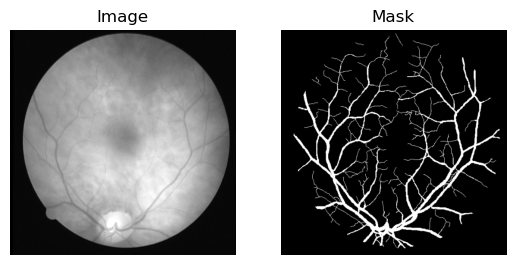

In [255]:
# Visualize the data
train_data = next(iter(train_loader))
image, mask = train_data["image"][0][0], train_data["mask"][0][0]
plot_vessel(image, mask)

In [256]:
# Define the MONAI UNet model
backbone = "resnet34"
model = UNet(
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    spatial_dims=2,
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

In [257]:
# Define the loss function
loss_function = DiceLoss(sigmoid=True)
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

In [258]:
# Define the training loop
max_epochs = 20
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
    with torch.set_grad_enabled(True):
        for batch in loop:
            inputs = batch["image"].to(device) / 255.0 # Normalize the input in the range [0, 1]
            labels = batch["mask"].to(device) / 255.0
    
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

Epoch 20/20: 100%|██████████| 20/20 [00:02<00:00,  7.37it/s, loss=0.563]


In [261]:
# Predict on the test set
def predict(model, loader):
    model.eval()
    with torch.no_grad():
        for batch_data in loader:
            inputs = batch_data["image"].to(device)
            outputs = model(inputs)
            yield outputs

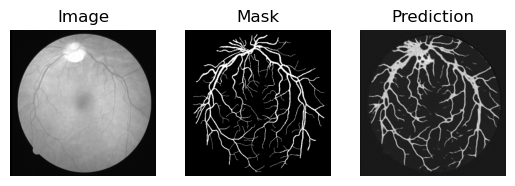

In [300]:
# Visualize the predictions (pick a random image)
rand_idx = np.random.randint(0, len(test_dataset))
rand_image = test_dataset[rand_idx]["image"]
rand_mask = test_dataset[rand_idx]["mask"]
rand_image = rand_image.unsqueeze(0).to(device)
rand_pred = model(rand_image)
plot_vessel_pred(rand_image[0][0].cpu().numpy(), rand_mask[0].cpu().numpy(), rand_pred[0][0].cpu().numpy())